In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.9 MB/s 
     |████████████████████████████████| 9.8 MB 59.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Import libraries

In [2]:
import pandas as pd
import torch
from pmdarima import auto_arima
from tqdm import tqdm
import warnings
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F


## Load data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/compressed_dataset.csv.zip',compression='zip',index_col=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20615370 entries, 0 to 20615369
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   int64  
 1   timestamp    int64  
 2   customer_id  float64
 3   event_id     float64
 4   viewer_id    float64
 5   city_id      float64
 6   country_id   float64
 7   viewer_type  object 
 8   qoe          float64
 9   engagement   float64
 10  buffer_ms    int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 1.7+ GB


## Extract features from timestamp

In [4]:
df = data.groupby('event_id')

events = list(df.groups.keys())

data = data.loc[data.event_id != events[len(events) - 1]]

data['date/time'] = pd.to_datetime(data['timestamp'],unit = 'ms')
data['date'] = data['date/time'].dt.date
data['time'] = pd.Series(data['date/time']).dt.round("T").dt.time
data['day_of_week'] = data['date/time'].dt.weekday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

## Find anomalies using the ARIMA method

We use the statistical method of ARIMA to detect anomalies. To find the best model for the data we use the auto-arima function. We set the threshold to 0.1

In [5]:
warnings.filterwarnings('ignore')

df = data[['event_id','time','qoe']].groupby('event_id')

events = list(df.groups.keys())

Y = torch.zeros(len(events))

for i in tqdm(range(len(events))):
  ## Delete the first and last three entries
  d = df.get_group(events[i]).groupby('time').mean().reset_index().drop('event_id',axis=1)
  d.drop(index=d.index[0], inplace=True)
  d.drop(index=d.index[d.index.shape[0] - 3:d.index.shape[0] - 1],inplace=True)
  ## Use auto arima to find the best model
  model = auto_arima(d.qoe,trace=False,stepwise=True)
  ## Calculate the residual with the time series
  d['pred'] = model.predict_in_sample(d.qoe)
  d['MSE'] = d['pred'] - d['qoe']
  ## Detect Anomalies
  if (d['MSE'] > 0.1).sum() != 0:
    Y[i] = 1

100%|██████████| 730/730 [18:17<00:00,  1.50s/it]


### Number of anomalies in the dataset

In [6]:
N = int((Y == 1).sum())
N

130

### Examples of time series with anomalies

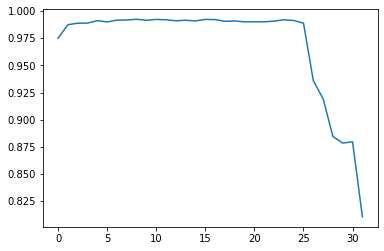

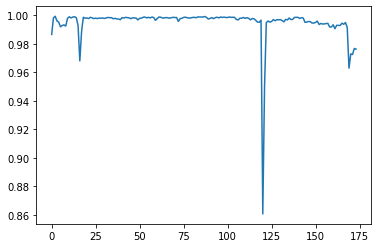

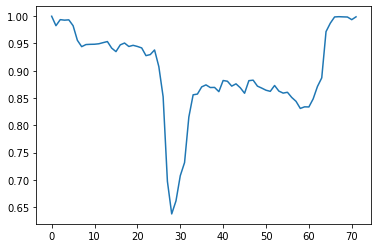

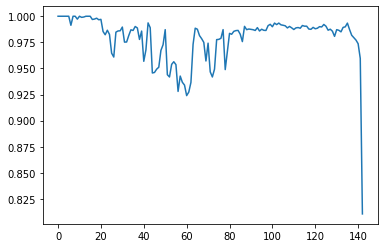

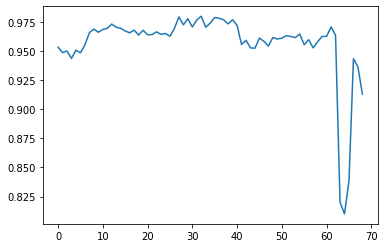

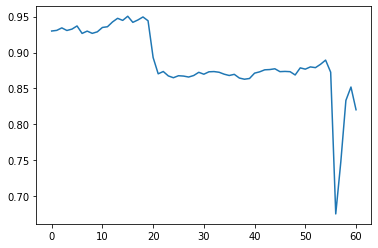

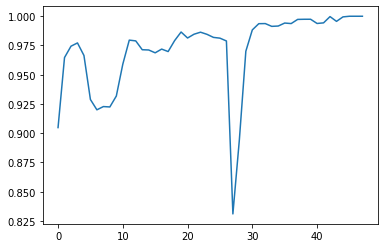

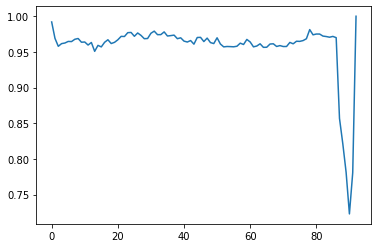

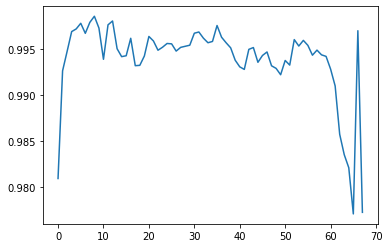

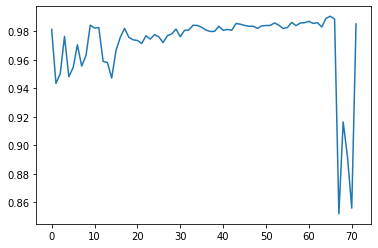

In [7]:
import matplotlib.pyplot as plt
i  = 0
counter = 0
while counter < 10:
  if Y[i] == 1:
    qoe = data.loc[data.event_id == events[i],['time','qoe']].groupby('time').mean().reset_index().qoe
    plt.plot(qoe)
    plt.show()
    counter += 1
  i+= 1

## Extract the features for the model

In [8]:
def Duration(X):
    l = X.tolist()
    l.sort()
    return l[-1] - l[0]

def Retention(series):
  lst = series.tolist()
  lst.sort()
  sum = 0
  for i in range(1,len(lst)):
    if lst[i] - lst[i-1] <= 30000: 
      sum += lst[i] - lst[i-1]
  return sum

In [9]:
#engagement = data[['event_id','time','engagement']].groupby('event_id').agg({'engagement':'mean'}).reset_index().engagement ## Mean value for engagement
buffer_ms = data[['event_id','buffer_ms']].groupby('event_id').mean().reset_index().buffer_ms ## Mean value for buffer_ms
countries = data[['event_id','country_id']].groupby('event_id').agg({'country_id':lambda x: x.drop_duplicates().count()}).reset_index().country_id ## Number of countries in the event
cities = data[['event_id','city_id']].groupby('event_id').agg({'city_id':lambda x: x.drop_duplicates().count()}).reset_index().city_id ## Number of cities in the event
number_of_viewers = data[['event_id','viewer_id']].groupby('event_id').agg({'viewer_id':lambda x: x.drop_duplicates().count()}).reset_index().viewer_id ## Number of viewers in the event
WFO_count = data[['event_id','viewer_type']].groupby('event_id').agg({'viewer_type' :lambda x: (x == 'WFO').sum()}).reset_index().viewer_type ## Number of WFO in the event
WFH_count = data[['event_id','viewer_type']].groupby('event_id').agg({'viewer_type' :lambda x: (x == 'WFH').sum()}).reset_index().viewer_type ## Number of WFH in the event
duration = data[['event_id','timestamp']].groupby('event_id').agg({'timestamp' :Duration}).reset_index().timestamp ## Duration of the event
retention = data[['event_id','viewer_id','timestamp']].groupby(['event_id','viewer_id']).agg({'timestamp':Retention}).reset_index().groupby('event_id').agg({'timestamp':'mean'}).reset_index().timestamp ## Mean retrntion in the event

## Scale the values using MinMaxScaler

In [10]:
df = pd.DataFrame({'buffer_ms':buffer_ms,'countries_count':countries,'cities_count':cities,'number_of_viewers':number_of_viewers,'WFO_count':WFO_count,'WFH_count':WFH_count,'duration':duration,'retention':retention})
cols = list(df.columns)

for col in cols:
  df[col] = MinMaxScaler().fit_transform(df[col].values.reshape(-1,1))

In [11]:
X = torch.tensor(df.to_numpy())

In [12]:
poses0 = (Y == 0).nonzero(as_tuple=True)[0]
poses1 = (Y == 1).nonzero(as_tuple=True)[0]

train_X = torch.zeros(2*(Y == 1).sum(),X.shape[1])
train_Y = torch.zeros(2*(Y == 1).sum())
counter = 0
counter_zeros = 0
i = 0
while i < (2*(Y == 1).sum()):
  train_X[i] = X[poses0[counter_zeros]]
  train_Y[i] = Y[poses0[counter_zeros]]
  counter_zeros += 1
  i += 1
  train_X[i] = X[poses1[counter]]
  train_Y[i] = Y[poses1[counter]]
  counter += 1
  i+= 1
  



## Create custom dataset for tensors

In [13]:
class CustomDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.y = Y

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index],self.y[index]


dataset = CustomDataset(train_X,train_Y)
train_size = int(0.75 * train_X.shape[0])
test_size = train_X.shape[0] - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



## Create neural net class

In [14]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(8, 10),
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10, 10),
      nn.ReLU(),
      nn.Linear(10,1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

## Train the model

In [15]:
mlp = MLP()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

dataloader = DataLoader(dataset=train_dataset,batch_size = 10,shuffle=True)

for EPOCH in range(3500):
    current_loss = 0.0
    for i, data_i in enumerate(dataloader, 0):
        inputs, targets = data_i
        optimizer.zero_grad()
        outputs = mlp.forward(inputs.float())
        loss =  loss_function(outputs.flatten(), targets.float())
        loss.backward() 
        optimizer.step()
        current_loss += loss.item()
    if EPOCH%50 == 0:
        print(current_loss)

13.967109680175781
8.562036871910095
6.647926926612854
5.805539548397064
5.272475525736809
4.625716742128134
4.789165643975139
4.82597566023469
4.319736782461405
4.229245439171791
4.147952102124691
4.141884978860617
4.071279902011156
4.082570679485798
3.999015361070633
4.1963400430977345
4.2064480520784855
3.7723568566143513
3.713999528437853
3.681801751255989
3.673006519675255
3.6691477485001087
3.5929356701672077
3.5708740465343
3.54474039003253
3.7085160203278065
3.507671555504203
3.99835111387074
3.7973966524004936
3.587772523984313
3.4648120142519474
3.4002724159508944
3.563120011240244
3.3955638110637665
3.34822129458189
3.2875560773536563
3.2010327745229006
3.1636792719364166
3.5821456275880337
3.1351832281798124
3.0986795546486974
3.0654954072088003
3.0285675628110766
3.333123179152608
3.1664483286440372
2.9550097277387977
3.0714625595137477
2.851923367008567
2.8107613436877728
2.755642200820148
2.8000428378582
2.6766177229583263
2.9872500458732247
2.6372665241360664
2.55767865

## Evaluate training dataset

In [16]:
dataloader = DataLoader(dataset=train_dataset,shuffle=True)

y_pred = []
y_true = []
for i, data_i in enumerate(dataloader, 0):
  inputs, targets = data_i
  outputs = mlp.forward(inputs.float())
  y_true.append(int(targets))
  if outputs > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)



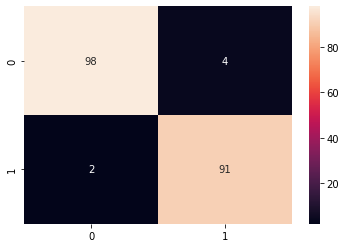

In [17]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

sns.heatmap(data=confusion_matrix(y_true,y_pred),annot=True)

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true,y_pred)

0.9692307692307692

## Evaluate test dataset

In [19]:
dataloader = DataLoader(dataset=test_dataset,shuffle=True)
y_pred = []
y_true = []
for i, data_i in enumerate(dataloader, 0):
  inputs, targets = data_i
  outputs = mlp.forward(inputs.float())
  y_true.append(int(targets))
  if outputs > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

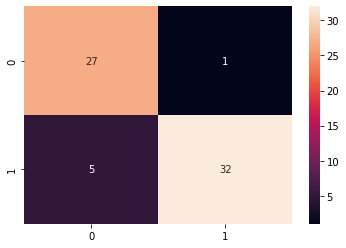

In [20]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

sns.heatmap(data=confusion_matrix(y_true,y_pred),annot=True)

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true,y_pred)

0.9076923076923077

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X.detach().numpy(),train_Y.detach().numpy(),test_size = 0.2)

## Logistic Regression

0.8413461538461539
0.7692307692307693


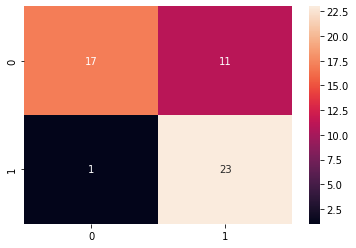

In [39]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression().fit(X_train,y_train)

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)

## Random Forest

1.0
0.9230769230769231


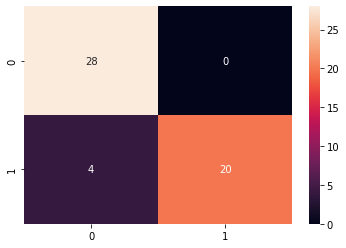

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X_train,y_train)

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X.detach().numpy(),Y.detach().numpy(),test_size = 0.2)

1.0
0.8424657534246576


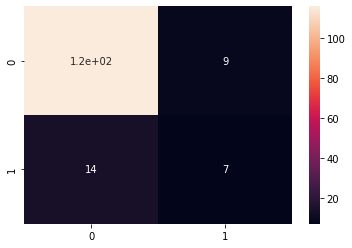

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X_train,y_train)

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)

## SVM

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_X.detach().numpy(),train_Y.detach().numpy(),test_size = 0.2)

0.9134615384615384
0.8846153846153846


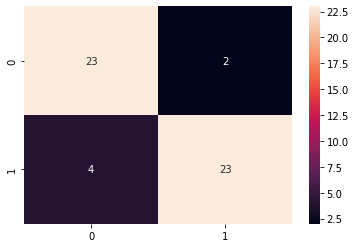

In [44]:
from sklearn.svm import SVC

clf = SVC().fit(X_train,y_train)

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X.detach().numpy(),Y.detach().numpy(),test_size = 0.2)

0.815068493150685
0.8561643835616438


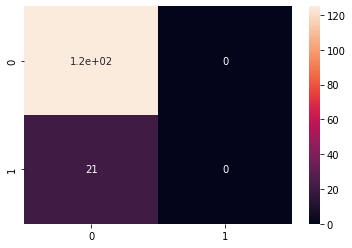

In [46]:
from sklearn.svm import SVC

clf = SVC().fit(X_train,y_train)

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)